In [ ]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn 

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from prophet import Prophet

# from google.colab import files # type: ignore

# # Upload files to Google Colab
# uploaded = files.upload()

import warnings
warnings.filterwarnings('once')

Initializing time series

In [85]:
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv', sep=';')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True) # white-box model formatting

def sample_data(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

date_start = '2023-11-01'
window_train_size = 24*7*2 #hours
forecast_horizon = 24 #hours

data = sample_data(df, date_start, window_train_size) # gets sufficient data for train set before set start date

for i in range(2):
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)

  # insert model here
  model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12))
  model_res = model.fit(disp=0)
  predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean

  print(data.index[0])
  print(predictions_statsmodels)
  data = data.iloc[forecast_horizon:] # remove the n first elements from the data



c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

2023-10-18 00:00:00
336    29580.580934
337    27656.584572
338    26708.467430
339    26348.222565
340    26395.721958
341    24562.114739
342    23975.294788
343    28567.619304
344    31556.801365
345    30629.755987
346    30547.485134
347    29781.010808
348    29850.174302
349    30477.204012
350    30819.874664
351    31635.086560
352    34249.108786
353    43480.031815
354    57271.968120
355    54864.491897
356    48215.294188
357    44332.208966
358    40926.566029
359    36005.020045
Name: predicted_mean, dtype: float64


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-10-19 00:00:00
336    32411.030538
337    33163.143637
338    30721.370292
339    30810.398821
340    30343.911376
341    29405.162593
342    30590.963468
343    34975.249989
344    36876.604567
345    34978.328802
346    33925.359117
347    32650.762527
348    32521.442214
349    33207.178016
350    32541.619615
351    33448.833613
352    36633.577567
353    45393.248171
354    57996.134452
355    55537.021307
356    49105.674771
357    44515.239549
358    41319.262235
359    37519.010088
Name: predicted_mean, dtype: float64


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Training Set: 25512 rows
Test Set: 8281 rows
HourDK
2021-01-01 01:00:00    35086.772
2021-01-01 02:00:00    31777.762
2021-01-01 03:00:00    28423.659
2021-01-01 04:00:00    25675.926
2021-01-01 05:00:00    24283.909
                         ...    
2024-11-10 19:00:00    48584.696
2024-11-10 20:00:00    44105.371
2024-11-10 21:00:00    41492.172
2024-11-10 22:00:00    37148.073
2024-11-10 23:00:00    33307.696
Name: ConsumptionkWh, Length: 33839, dtype: float64


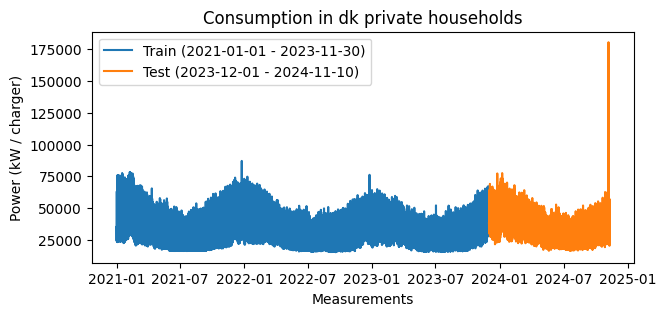

In [4]:
# Correct the file path to the actual location of the CSV file
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv', sep=';')
# df = pd.read_csv('ConsumptionIndustry.csv', sep=';')

# Convert HourDK to datetime
df['HourDK'] = pd.to_datetime(df['HourDK'])

# Convert ConsumptionkWh to numeric
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)

train_start = "2021-01-01"
train_end = "2023-11-30"
test_start = "2023-12-01"
test_end = "2024-11-10"

df.index = df['HourDK']

df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)
data_train = df[(df.index >= train_start) & (df.index <= train_end)]
data_test = df[(df.index >= test_start) & (df.index <= test_end)]

print(f"Training Set: {data_train.shape[0]} rows")
print(f"Test Set: {data_test.shape[0]} rows")

df = df['ConsumptionkWh']
print(df)
# print(data_train)
# print(data_test)
plt.figure(figsize=(7, 3))
plt.plot(data_train.index, data_train['ConsumptionkWh'], label=f'Train ({train_start} - {train_end})')
plt.plot(data_test.index, data_test['ConsumptionkWh'], label=f'Test ({test_start} - {test_end})')
plt.title('Consumption in dk private households')
plt.xlabel('Measurements')
plt.ylabel('Power (kW / charger)')
plt.legend()
plt.show()

Models and predictions

In [5]:
# model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12))
# model_res = model.fit(disp=0)

# predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
# predictions_statsmodels.name = 'predictions_statsmodels(1,1,1)'
# # display(predictions_statsmodels.head(4))

In [6]:
# model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12))
# model_res = model.fit(disp=0)

# predictions_statsmodels2 = model_res.get_forecast(steps=len(data_test)).predicted_mean
# predictions_statsmodels2.name = 'predictions_statsmodels(1,1,4)'

In [7]:
# stlf = STLForecast(data_train, SARIMAX, model_kwargs=dict(order=(1, 1, 1), seasonal_order = (1, 1, 1, 12)), period=24)
# model_res = stlf.fit()
# predictions_stlf = model_res.forecast(len(data_test))

In [8]:
# model = ThetaModel(data_train, period=24, method="additive")
# model_res = model.fit()
# predictions_theta = model_res.forecast(len(data_test))
# predictions_theta.index = data_test.index

# model2 = ThetaModel(data_train, period=24, method="multiplicative")
# model2_res = model2.fit()
# predictions_theta2 = model2_res.forecast(len(data_test))
# predictions_theta2.index = data_test.index

In [9]:
# model = DynamicFactorMQ(endog=data_train)
# model_res = model.fit()
# predictions_dynamicFactorMQ = model_res.forecast(len(data_test))

Plot of forecasts

In [10]:
# predictions_statsmodels.index = data_test.index
# predictions_statsmodels2.index = data_test.index
# predictions_stlf.index = data_test.index
# predictions_theta.index = data_test.index
# predictions_theta2.index = data_test.index
# predictions_dynamicFactorMQ.index = data_test.index

In [11]:
# fig, ax = plt.subplots(figsize=(8, 3))
# data_train.plot(ax=ax, label='train')
# data_test.plot(ax=ax, label='test')
# predictions_statsmodels.plot(ax=ax, label='arima_statsmodels(1,1,6)x(1,1,1)_12')
# # predictions_statsmodels2.plot(ax=ax, label='arima_statsmodels(1,1,4)x(1,1,1)_12')
# # predictions_dynamicFactorMQ.plot(ax=ax, label='dynamicFactorMQ')
# # predictions_stlf.plot(ax=ax, label='stlf')
# # predictions_theta.plot(ax=ax, label='theta')
# # predictions_theta2.plot(ax=ax, label='theta2')
# ax.set_title('Predictions')
# ax.legend()

Evaluate algorithm performance

In [13]:
# def evaluate(prediction, name):
#     print(f"-- {name} --")
#     print(f"mse: {mean_squared_error(data_test, prediction)}") #penalizes larger errors more
#     print(f"rmse: {mean_squared_error(data_test, prediction, squared=False)}")

# evaluate(predictions_statsmodels, "statsmodels(1,1,6)x(1,1,1)_12")
# evaluate(predictions_statsmodels2, "statsmodels(1,1,4)x(1,1,1)_12")
# evaluate(predictions_stlf, "stlf")
# evaluate(predictions_theta, "theta")
# evaluate(predictions_theta2, "theta2")
# evaluate(predictions_dynamicFactorMQ, "dynamicFactorMQ")

Automating finding best parameters

In [24]:
def optimize_SARIMAX(endog):
  results = []
  p = d = q = range(0, 1)
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
      try:
          model = SARIMAX(endog, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False).fit(maxiter=200, disp=0) #disp=0 to reduce output verbosity
      except:
          continue

      aic = model.aic
      rmse = mean_squared_error(endog, model.fittedvalues, squared=False)
      results.append([f"{param}x{seasonal_param}", aic, rmse])

  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic', 'rmse']
  result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)

  return result_table

optimize_SARIMAX(data_train)

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,parameters,aic,rmse
0,"(0, 0, 0)x(0, 0, 0, 12)",604782.730778,34009.501736
